In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.cm as cm


In [2]:
# import torch
# print(torch.cuda.get_device_name(0))

In [3]:
# Download training data from open datasets.
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.93MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
def normalize(data):
  # get mean and std.
  mean = np.mean(data, axis=0)
  std_dev = np.std(data, axis=0)

  # reenforce the division not 0
  std_dev[std_dev == 0] = 1

  #  x = (x-mean) / std
  data = (data - mean) / std_dev
  return data

def preprocess_data(data):
  X = []  # (60000, 784)
  Y = []  # (60000,)
  for image_tensor, label in data:
    # Reshape each image to a flat vector of 784 elements and convert to a numpy array
    X.append(image_tensor.numpy().reshape(784))

    # rewrite the label to (0 if label between 0-4) or (1 if 5-9)
    if label <= 4:
      Y.append(0)
    else:
      Y.append(1)

  X = np.array(X, dtype=np.float32) # without enforece the dtype, may unable to process
  Y = np.array(Y, dtype=np.int64)
  X = normalize(X)     # normalize feature

  X = np.hstack([X, np.ones((X.shape[0], 1))])  # Add bias column

  return X, Y

In [5]:
X_train,Y_train = preprocess_data(train_data)
X_test, Y_test = preprocess_data(test_data)
print("X_train:", X_train.shape)
print("y_train:",Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

print(np.std(X_train))

X_train: (60000, 785)
y_train: (60000,)
X_test: (10000, 785)
Y_test: (10000,)
0.9563967519997209


In [6]:
# XO, YO = X_train,Y_train
# X_train,Y_train = X_train[0:10000],Y_train[0:10000]

In [7]:
# How to implement Linear Regression from scratch with Python https://www.youtube.com/watch?v=ltXSoduiVwY
class LinearRegression:
  def __init__(self, lr=0.01, epochs=10):
    self.lr = lr
    self.epochs = epochs
    self.weights = None

  def train(self, X, y):
    n_samples, n_features = X.shape
    self.weights = np.zeros(n_features)

    for epoch in range(self.epochs):
      y_pred = np.dot(X, self.weights)  # f(x) = wx as linaer regression

      loss = y - y_pred # compute loss

      dw = np.dot(X.T, loss) / n_samples
      self.weights -= self.lr * dw

      if epoch % 10 == 0:  # track losss as mean square error
        print(epoch, " \niter, Loss: ", np.mean(loss**2))
        print(" iter, accuracy: ",self.accuracy(X, y))

  def predict(self, X):
    return (np.dot(X, self.weights) > 0.5) #Return if prediction has higher probablity to classfy a datapoint > 4

  def accuracy(self, X, y):
    y_pred = self.predict(X)
    return np.mean(y_pred == y)

In [8]:
#problem 1, linear classfication
linear_model = LinearRegression(lr=0.00001, epochs=100)
linear_model.train(X_train,Y_train)
#linear_model.train(XO,YO)
print("Accuracy:", linear_model.accuracy(X_test, Y_test))

0  
iter, Loss:  0.49006666666666665
 iter, accuracy:  0.5099333333333333
10  
iter, Loss:  0.4904811639864403
 iter, accuracy:  0.5099333333333333
20  
iter, Loss:  0.49089734637672244
 iter, accuracy:  0.5099333333333333
30  
iter, Loss:  0.49131522333278865
 iter, accuracy:  0.5099333333333333
40  
iter, Loss:  0.49173480440979805
 iter, accuracy:  0.5099333333333333
50  
iter, Loss:  0.4921560992231988
 iter, accuracy:  0.5099333333333333
60  
iter, Loss:  0.4925791174491346
 iter, accuracy:  0.5099333333333333
70  
iter, Loss:  0.4930038688248563
 iter, accuracy:  0.5099333333333333
80  
iter, Loss:  0.4934303631491348
 iter, accuracy:  0.5099333333333333
90  
iter, Loss:  0.4938586102826774
 iter, accuracy:  0.5099333333333333
Accuracy: 0.5139


### ------------------------Dividing line--------------------


In [9]:
# this structure of this neural network browesd https://github.com/OriYarden/Binary-MultiClassificationNeuralNetworksFromScratchNumpyArraysOnlyPython
class NeuralNetwork:
  def __init__(self, n_neurons=10, lr=0.0001, epochs=10, loss_fun="quadratic", batch=10):
    self.n_neurons = n_neurons
    self.lr = lr
    self.epochs = epochs

    self.loss_fun = loss_fun

    self.W = None
    self.v = None
    self.batch = batch

  #  Xaiver initialization for neural network
  # https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
  @staticmethod
  def xavier_initialization(n_in, n_out):
    limit = np.sqrt(1 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=(n_in, n_out))

  def initialize_weights(self, n_features):
    # for the layers, input 785 feature with 60k datapoints, after layer1 become 5,50,200 scalar. h(x_train, weight) = X*W_T
    np.random.seed(42)
    self.W = self.xavier_initialization(self.n_neurons, n_features)
    # self.v = self.xavier_initialization(self.n_neurons, 1)
    self.v = self.xavier_initialization(self.n_neurons, 1).reshape(-1) # make it vector instead of matrix
    # print(self.W.shape, "Wshape")
    # print(self.v.shape, "vshape")

  def relu(self, x):
    x = np.maximum(0, x)
    return x

  def sigmoid(self, x):
    z = (1 + np.exp(-x))
    return 1 / z

  def forward_pass(self, X_batch):
    # print(self.W.shape, "forward, W")
    WT= self.W.T
    # print(X_batch.shape, "forward, X_Batch")
    # #print(WT.shape, "forward, W_T")
    h1_input = np.dot(X_batch, WT)
    h1_output = self.relu(h1_input) # call the relu activation function to get output from layer1
    # print(self.v.shape)
    h1_pred = np.dot(h1_output, self.v) # the output layer
    # print(h1_pred.shape)
    return h1_input, h1_output, h1_pred

  # def dRelu(self,X):
  #   if X > 0:
  #     return 1
  #   else:
  #     return 0

  def dRelu(self, X):
    return (X > 0) * 1 #Consider X is matrix form, for all of its element, if greater than0 output True, mult 1 make it numerical

  def train(self, X, y):
    n_samples, n_features = X.shape #get number of samples, feather, dimension
    # print(n_samples.shape)
    # print(n_features.shape)
    self.initialize_weights(n_features) #initialize with Xaiver distribution

    # print(self.initialize_weights.shape)
    # test = np.dot(X, self.W.T)
    # print(test, "forward propa")
    # print(test.shape, "forward propa")

    batch_size = self.batch
    accuracies = []

    for epoch in range(self.epochs):
      for i in range(0, X.shape[0], batch_size):
        # choose the batch datapoints
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]

        #forward fass
        h1_input, h1_output, h1_pred = self.forward_pass(X_batch)

        # compute loss as quadratic fun
        if self.loss_fun == "quadratic":
          loss = y_batch - h1_pred
          # print(loss.shape)

          h1_loss = -loss  # compute the h1 layers' loss as quardatic. Have to negate the loss to specifiy the direction of gradient approaching

        # compute loss as logsitc fun
        elif self.loss_fun == "logistic":
          # use sigmoid to compute the probability first
          h1_pred_sigmoid = self.sigmoid(h1_pred)
          # then compute the loss based some sigmoid with y_batch the actual target
          loss = y_batch - h1_pred_sigmoid
          # print(loss.shape)

          # compute the h1 layers' loss as sigmod
          #print("logsic before: -loss, h1Pred_Sigmoid, sigDerivaitve", (-loss).shape, h1_pred_sigmoid.shape, (1-h1_pred_sigmoid).shape)
          h1_loss = -loss * h1_pred_sigmoid *(1-h1_pred_sigmoid)  # sigmod(x) * (1 - sigmoid(x))

          # logsic: h1_loss, -loss, h1Pred_Sigmoid, sigDerivaitve (10000,) (10000,) (10000,) (10000,) 10000 == batch_size
          #print("logsic after: h1_loss, -loss, h1Pred_Sigmoid, sigDerivaitve", h1_loss.shape,(-loss).shape, h1_pred_sigmoid.shape, (1-h1_pred_sigmoid).shape)

        # Backprop for v
        dv = np.dot(h1_loss, h1_output) / batch_size
        # print(self.v.shape)

        # Backprop for W
        dRelu = h1_loss[:, np.newaxis] * self.v * self.dRelu(h1_input)# -loss[:, np.newaxis] add a new col to match dimension. multi with outMatrix v to connect neurons, dot with derivative of relu matrix
        dw = np.dot(dRelu.T, X_batch) / batch_size
        # print(self.W.shape)

        # Update w and v
        self.v -= self.lr*dv
        self.W -= self.lr*dw
        # print(self.v.shape)
        # print(self.W.shape)

        # Track accuracy every 20,000 datapoints passed
        if i % 20000 == 0:
          ith_accuracy = self.accuracy(X, y)
          #print(ith_accuracy)
          accuracies.append(ith_accuracy)
    return accuracies

  def predict(self, X):
    h1_input, h1_output, h1_pred = self.forward_pass(X)
    if self.loss_fun == "logistic":
        return self.sigmoid(h1_pred) > 0.5
    else:
        return h1_pred > 0.5

  def accuracy(self, X, y):
    h1_pred = self.predict(X)
    return np.mean(h1_pred == y)


In [10]:
k = [5,50,200]
kth_quadTrain_Accuracies = []
for neurons in k:
    quadraticNN = NeuralNetwork(n_neurons=neurons, lr=0.001, epochs=10, batch=10, loss_fun="quadratic")
    train_accuracies = quadraticNN.train(X_train,Y_train)
    kth_quadTrain_Accuracies.append(train_accuracies)

    final_test_accuracy = quadraticNN.accuracy(X_test, Y_test)
    print("Quadratic nn for # neuron = ", neurons, " final test Accuracy: ", final_test_accuracy)


Quadratic nn for # neuron =  5  final test Accuracy:  0.9413
Quadratic nn for # neuron =  50  final test Accuracy:  0.9595
Quadratic nn for # neuron =  200  final test Accuracy:  0.9629


In [11]:
def plot_accuracies(kth_accuracies, neurons, title):
    for i, train_accuracies in enumerate(kth_accuracies):
        plt.plot(train_accuracies, label=str(neurons[i]) + " neurons")
    plt.xlabel("iter")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()


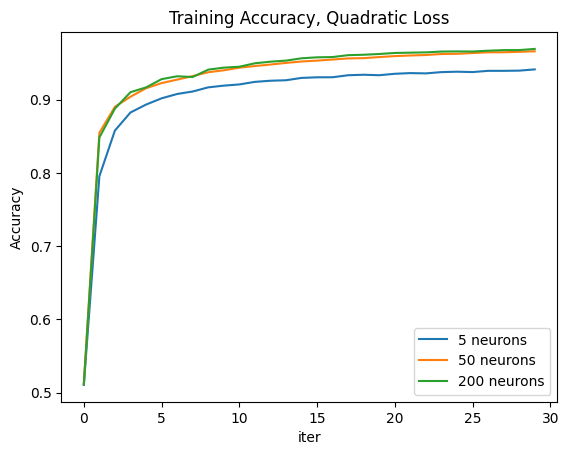

In [12]:
plot_accuracies(kth_quadTrain_Accuracies, k, title="Training Accuracy, Quadratic Loss")

In [13]:
k = [5,50,200]
kth_logTrain_Accuracies = []
for neurons in k:
    logisticNN = NeuralNetwork(n_neurons=neurons, lr=0.001, epochs=10, batch=10, loss_fun="logistic")
    train_accuracies = logisticNN.train(X_train,Y_train)
    kth_logTrain_Accuracies.append(train_accuracies)

    # Print final test accuracy
    final_test_accuracy = logisticNN.accuracy(X_test, Y_test)
    print("Logisctic nn for # neuron = ", neurons, " final test Accuracy: ", final_test_accuracy)


Logisctic nn for # neuron =  5  final test Accuracy:  0.9226
Logisctic nn for # neuron =  50  final test Accuracy:  0.9377
Logisctic nn for # neuron =  200  final test Accuracy:  0.9372


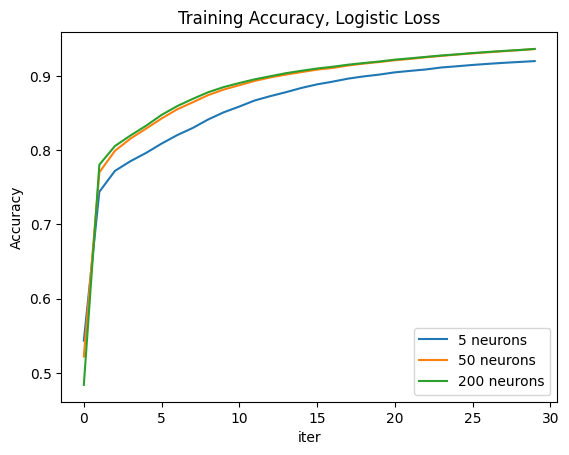

In [14]:
plot_accuracies(kth_logTrain_Accuracies, k, title="Training Accuracy, Logistic Loss")

In [15]:
k = [5,50,200]
kth_logTrain_Accuracies2 = []
for neurons in k:
    nn_model = NeuralNetwork(n_neurons=neurons, lr=0.0001, epochs=100, batch=10, loss_fun="logistic")
    train_accuracies = nn_model.train(X_train,Y_train)
    kth_logTrain_Accuracies2.append(train_accuracies)

    # Print final test accuracy
    final_test_accuracy = nn_model.accuracy(X_test, Y_test)
    print("Logisctic nn for # neuron = ", neurons, " final test Accuracy: ", final_test_accuracy)

# # Plot training accuracy over epochs
# plot_accuracies(train_accuracies, title="Neural Network Training Accuracy - Quadratic Loss")

Logisctic nn for # neuron =  5  final test Accuracy:  0.923
Logisctic nn for # neuron =  50  final test Accuracy:  0.9376
Logisctic nn for # neuron =  200  final test Accuracy:  0.9378


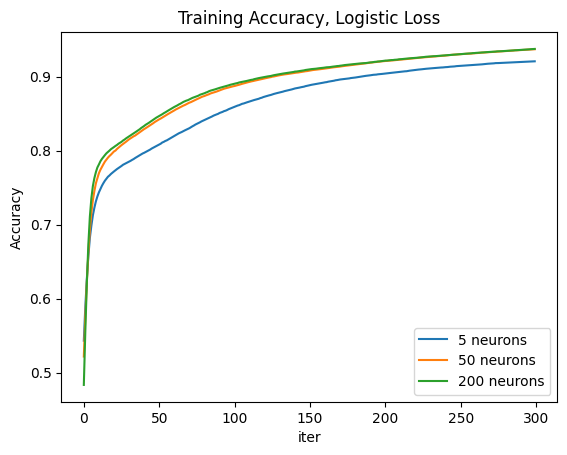

In [16]:
plot_accuracies(kth_logTrain_Accuracies2, k, title="Training Accuracy, Logistic Loss")